In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.
c:\users\msi1\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\msi1\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\msi1\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [65]:
(X,_),(_,_) = mnist.load_data()

X = (X.astype('float32') - 127.5)/127.5
X = X.reshape(60000,-1)

In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import *

In [68]:
generator = Sequential()

generator.add(Dense(256, input_shape = (100,)))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))

generator.add(Dense(784,activation='tanh'))

from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 0.0001, beta_1 = 0.5)
              
generator.compile(optimizer = adam, loss= 'binary_crossentropy') 


In [69]:
generator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 784)             

In [70]:
discriminator = Sequential()

discriminator.add(Dense(512, input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(optimizer=adam, loss='binary_crossentropy')

In [71]:
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [72]:
discriminator.trainable = False

ip = Input(shape=(100,))
intermed = generator(ip)

op = discriminator(intermed)

model = Model(ip,op)

model.compile(optimizer=adam, loss='binary_crossentropy')

In [73]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 784)               1486352   
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


In [57]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 1,067,010
Trainable params: 533,505
Non-trainable params: 533,505
_________________________________________________________________


In [80]:
def show_imgs(epoch):
    
    noise = np.random.normal(0,1,size=(100,100))
    fake_imgs = generator.predict(noise)
    fake_imgs = fake_imgs.reshape(100,28,28)
    
#     fake_imgs = (fake_imgs+1)*0.5

    # Plot
    plt.figure(figsize=(10,10))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(fake_imgs[i],interpolation = 'nearest',cmap='gray')
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('images/gan_output_{0}.png'.format(epoch+1))

512/512 [==============================] - 1s 1ms/sample - loss: 0.7685


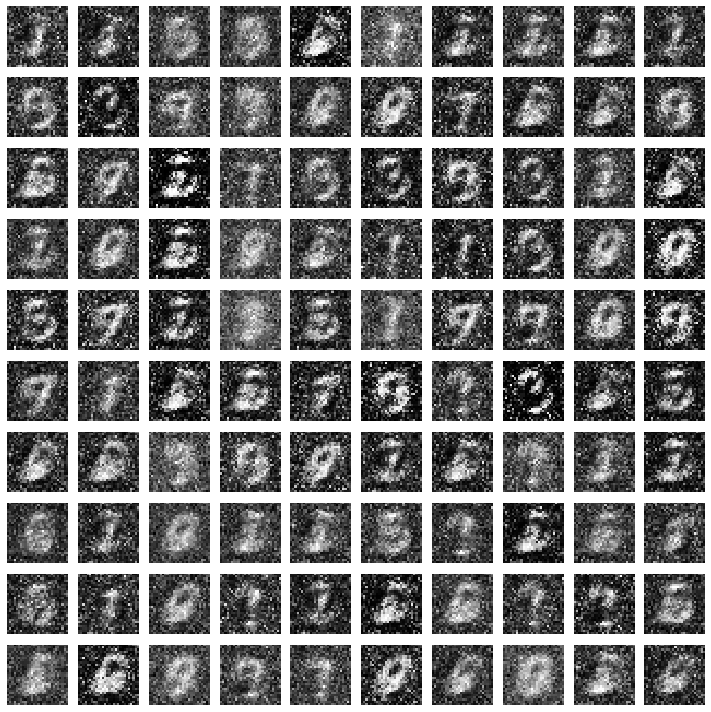

In [81]:
epochs = 50
batch_size = 256
half = 128

for e in range(epochs) :
    
    noise = np.random.normal(0,1,size=(batch_size,100))
    rand_idx = np.random.randint(low=0, high=X.shape[0],size=batch_size)
    
    
    real_labels = np.ones((batch_size,))
    fake_labels = np.zeros((batch_size,))
    
    real_imgs = X[rand_idx]
    fake_imgs = generator.predict(noise)
    
    show_imgs(e)
    
    d1_loss = discriminator.fit(real_imgs,real_labels)
    d2_loss = discriminator.fit(fake_imgs,fake_labels)
#     d_loss.append((d1_loss+d2_loss)/2)
    
    
    modelFeed = np.random.normal(0,1,size=(2*batch_size,100))
    ground_truth = np.ones((2*batch_size,))
    
    m_loss = model.fit(modelFeed,ground_truth)
    gen_loss.append(m_loss)
    
#     loss.append((d1_loss + d2_loss + m_loss)/3)
    

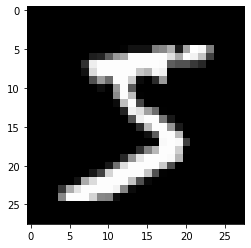

In [66]:
plt.imshow(X[0],cmap='gray')

In [61]:
f = np.random.normal(0,1,size=(100,))
f = f.reshape((1,100))
output = generator.predict(f)

In [63]:
(output+1)*0.5

array([[0.29347736, 0.3949245 , 0.3504482 , 0.37502924, 0.185922  ,
        0.2685785 , 0.39426926, 0.27781886, 0.28404891, 0.25499573,
        0.38488466, 0.33781034, 0.38566965, 0.276654  , 0.31772816,
        0.22416717, 0.35145122, 0.21941361, 0.32728398, 0.4005483 ,
        0.2275944 , 0.3443271 , 0.31032926, 0.22638276, 0.19520494,
        0.29975095, 0.27375916, 0.18594182, 0.444306  , 0.25941828,
        0.3398829 , 0.24130571, 0.2728706 , 0.32153   , 0.5031432 ,
        0.4301015 , 0.24526978, 0.36483324, 0.34783518, 0.17281368,
        0.36171144, 0.4404625 , 0.27869457, 0.29925984, 0.38925138,
        0.27523556, 0.33043188, 0.1978803 , 0.2360524 , 0.36034095,
        0.2985173 , 0.28211766, 0.24322009, 0.22681072, 0.25199443,
        0.2619226 , 0.29633075, 0.452591  , 0.3405934 , 0.4778468 ,
        0.2641978 , 0.26879555, 0.3210054 , 0.20072341, 0.2654371 ,
        0.3302831 , 0.2803494 , 0.35171157, 0.24934104, 0.23746899,
        0.46717405, 0.31178093, 0.18606406, 0.33

In [66]:
X.shape

(60000, 784)

In [67]:
X[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  